# Stellar Object Classification 

This project aims to develop machine learning models to classify celestial objects into stars, galaxies, and quasars <br> and aims to faciltate efficient automated classification, insights into distinguishing features, and optimized data processing for large-scale surveys through the predictive models, data visualizations, and a comparative analysis of various algorithms.

Data Collected by CAS, Swinburne, Australia

## Feature Description: 
<br> 1. **obj_ID**: Object Identifier, the unique value that identifies the object in the image catalogue used by the CAS 
<br> 2. **alpha**: Right Ascension angle (at J2000 epochs)
<br> 3. **delta**: Declination angle (at J2000 epoch)
<br> 4. **u**: Ultraviolet filter in the photometric system
<br> 5. **g**: Green filter in the photometric system
<br> 6. **r**: Red filter in the photometric system
<br> 7. **i**: Near Infrared filter in the photometric system
<br> 8. **z**: Infrared filter in the photometric system
<br> 9. **run_ID**: Run Number used to identify the specific scan
<br> 10. **rereun_ID**: Rerun Number to specify how the image was processed
<br> 11. **cam_col**: Camera column to identify the scanline within the run
<br> 12. **field_ID**: Field number to identify each field
<br> 13. **spec_obj_ID**: Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
<br> 14. **class**: object class (galaxy, star or quasar object)
<br> 15. **redshift**: redshift value based on the increase in wavelength
<br> 16. **plate ID**: plate ID, identifies each plate in SDSS
<br> 17. **MJD**: Modified Julian Date, used to indicate when a given piece of SDSS data was taken
<br> 18. **fiber_ID**: fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [6]:
# Importing all necessary libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder #Data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, PowerTransformer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report #Model evaluation
from imblearn.over_sampling import SMOTE # for handling imbalanced classes 
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier #implementing RFC's 
from sklearn.svm import SVC #implementing SVC's
from sklearn.tree import DecisionTreeClassifier #implementing DTC'c
from sklearn.impute import SimpleImputer # for null value imputation
import xgboost as xgb 
from xgboost import XGBClassifier #implementing XGBC
from sklearn.naive_bayes import MultinomialNB #implementing MNBC
from sklearn.neighbors import KNeighborsClassifier #implementing KNC
from sklearn.naive_bayes import GaussianNB #implementing NBC
from sklearn.compose import ColumnTransformer #combining the pipeline
from sklearn import set_config # Displaying the pipeline
from astropy.time import Time #for date manipulation
from statsmodels.tsa.seasonal import seasonal_decompose #for time series analysis
import matplotlib.dates as mdates#for time series analysis
import warnings
warnings.filterwarnings("ignore")
from scipy.stats.mstats import winsorize

## Exploratory Data Analysis

In [7]:
#importing the dataset
df=pd.read_csv('star_classification.csv') 

In [8]:
df.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [9]:
# Removing unnecessary columns
df_ids=[i for i in df.columns if i.__contains__('ID')]#remove cam_col too later
for i in df_ids:
    df=df.drop([i], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   cam_col   100000 non-null  int64  
 8   class     100000 non-null  object 
 9   redshift  100000 non-null  float64
 10  plate     100000 non-null  int64  
 11  MJD       100000 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 9.2+ MB


In [11]:
#Lets inspect the Target Variable values
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

<Axes: title={'center': 'Boxplot for redshift'}, xlabel='class', ylabel='redshift'>

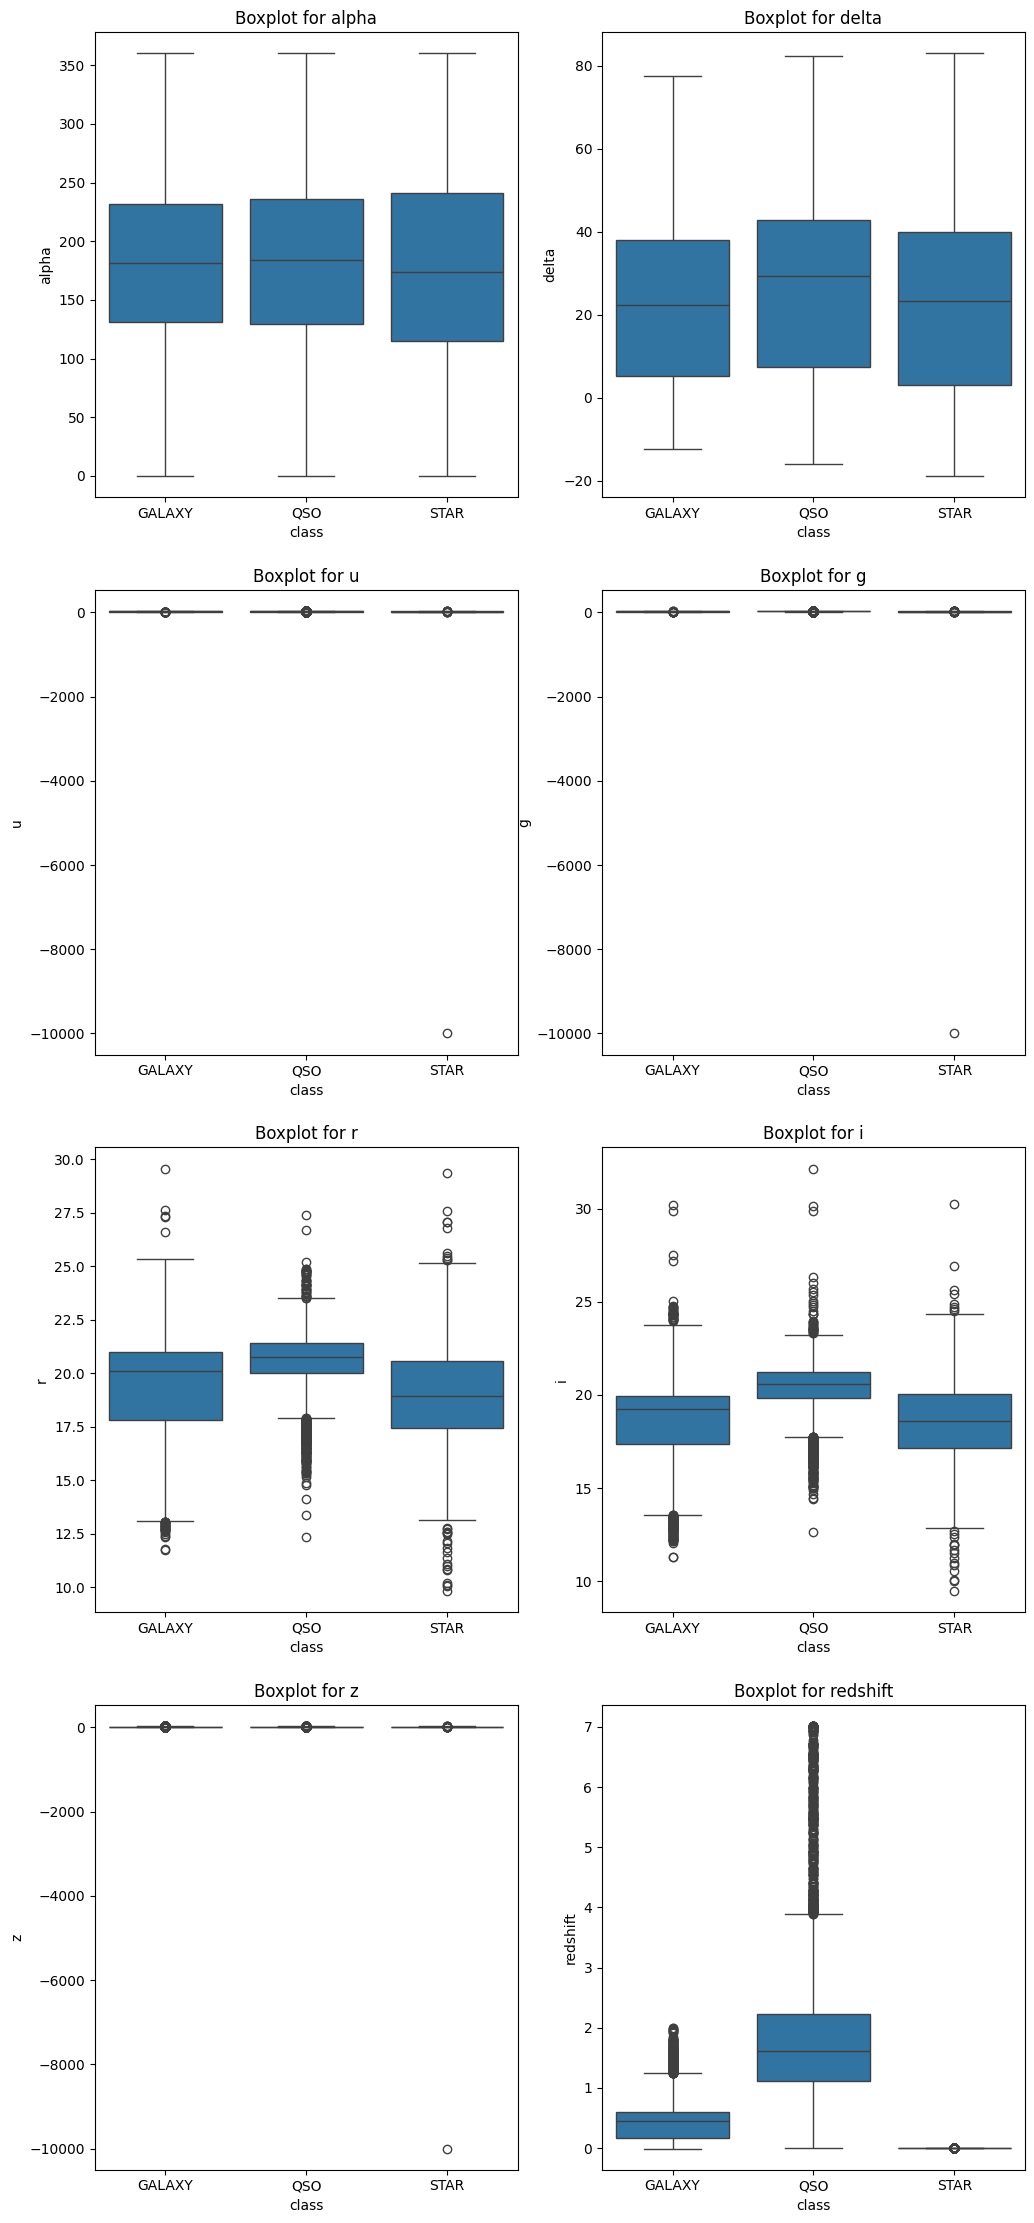

In [12]:
#Checking for outliers using boxplot
plt.figure(figsize=(12, 35))#Defining size of the plots
plt.subplot(5,2,1)
plt.title('Boxplot for alpha')#Giving title to each plots
sns.boxplot(x=df['class'], y=df['alpha'])
plt.subplot(5,2,2)
plt.title('Boxplot for delta')
sns.boxplot(x=df['class'], y=df['delta'])
plt.subplot(5,2,3)
plt.title('Boxplot for u')
sns.boxplot(x=df['class'], y=df['u'])
plt.subplot(5,2,4)
plt.title('Boxplot for g')
sns.boxplot(x=df['class'], y=df['g'])
plt.subplot(5,2,5)
plt.title('Boxplot for r')
sns.boxplot(x=df['class'], y=df['r'])
plt.subplot(5,2,6)
plt.title('Boxplot for i')
sns.boxplot(x=df['class'], y=df['i'])
plt.subplot(5,2,7)
plt.title('Boxplot for z')
sns.boxplot(x=df['class'], y=df['z'])
plt.subplot(5,2,8)
plt.title('Boxplot for redshift')
sns.boxplot(x=df['class'], y=df['redshift'])

In [13]:
df_num=df.select_dtypes(include=np.number)
from scipy.stats import shapiro
for i in df_num:
    stat, p_value = shapiro(df[i])
    print(f'Results for {i}')
    print(f"Shapiro-Wilk Test Statistic:{stat}")
    print(f"p-value: {p_value}")
    if p_value > 0.05:
        print("The data appears to follow a normal distribution.")
    else:
        print("The data does not follow a normal distribution.")
    print('-'*50)

Results for alpha
Shapiro-Wilk Test Statistic:0.9563737789475277
p-value: 1.02213401327866e-90
The data does not follow a normal distribution.
--------------------------------------------------
Results for delta
Shapiro-Wilk Test Statistic:0.9621126997592861
p-value: 2.789043649450643e-87
The data does not follow a normal distribution.
--------------------------------------------------
Results for u
Shapiro-Wilk Test Statistic:0.0072420271708125705
p-value: 3.2684703749834186e-184
The data does not follow a normal distribution.
--------------------------------------------------
Results for g
Shapiro-Wilk Test Statistic:0.0060387392646260585
p-value: 2.9624645513191885e-184
The data does not follow a normal distribution.
--------------------------------------------------
Results for r
Shapiro-Wilk Test Statistic:0.9624677187770521
p-value: 4.703216475993495e-87
The data does not follow a normal distribution.
--------------------------------------------------
Results for i
Shapiro-Wilk T

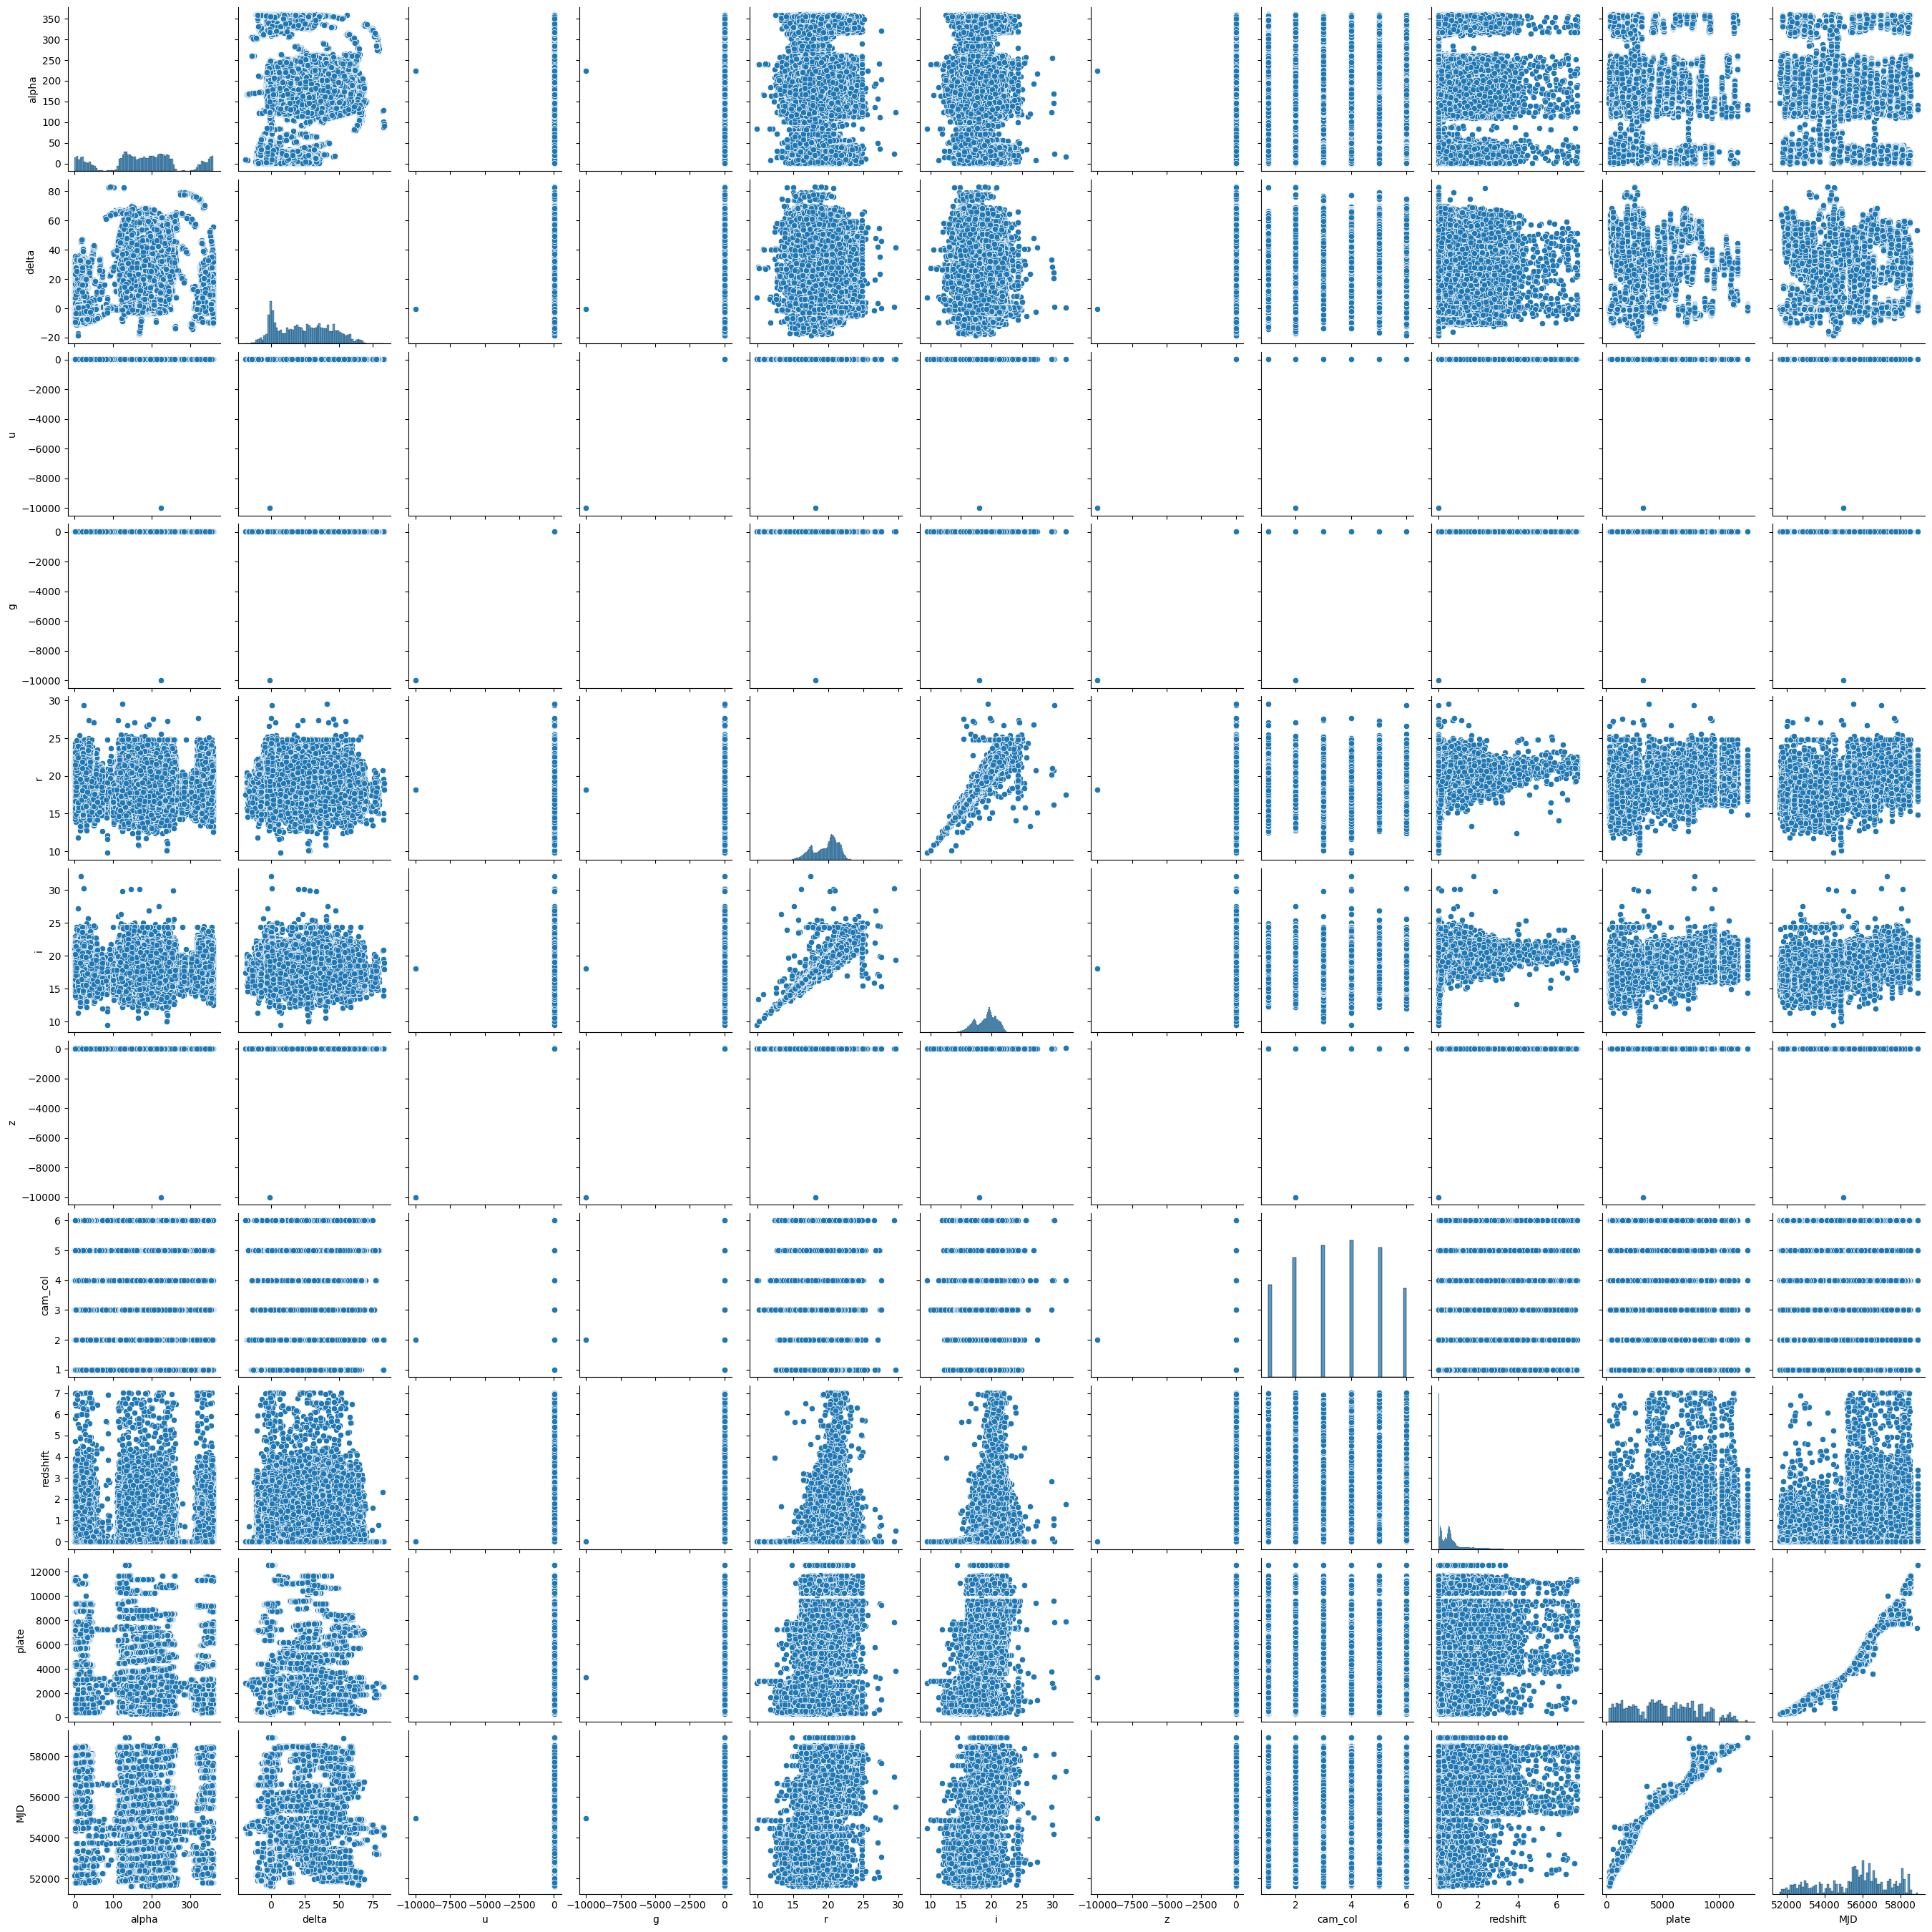

In [49]:
sns.pairplot(df_num)

In [14]:
df.describe()

alpha          delta              u              g  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      177.629117      24.135305      21.980468      20.531387   
std        96.502241      19.644665      31.769291      31.750292   
min         0.005528     -18.785328   -9999.000000   -9999.000000   
25%       127.518222       5.146771      20.352353      18.965230   
50%       180.900700      23.645922      22.179135      21.099835   
75%       233.895005      39.901550      23.687440      22.123767   
max       359.999810      83.000519      32.781390      31.602240   

                   r              i              z        cam_col  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       19.645762      19.084854      18.668810       3.511610   
std         1.854760       1.757895      31.728152       1.586912   
min         9.822070       9.469903   -9999.000000       1.000000   
25%        18.135828      17.732285      17.460677       2.000000   
50%        20.125290      19.405145      19.004595       4.000000   
75%        21.044785      20.396495      19.921120       5.000000   
max        29.571860      32.141470      29.383740       6.000000   

            redshift          plate            MJD  
count  100000.000000  100000.000000  100000.000000  
mean        0.576661    5137.009660   55588.647500  
std         0.730707    2952.303351    1808.484233  
min        -0.009971     266.000000   51608.000000  
25%         0.054517    2526.000000   54234.000000  
50%         0.424173    4987.000000   55868.500000  
75%         0.704154    7400.250000   56777.000000  
max         7.011245   12547.000000   58932.000000

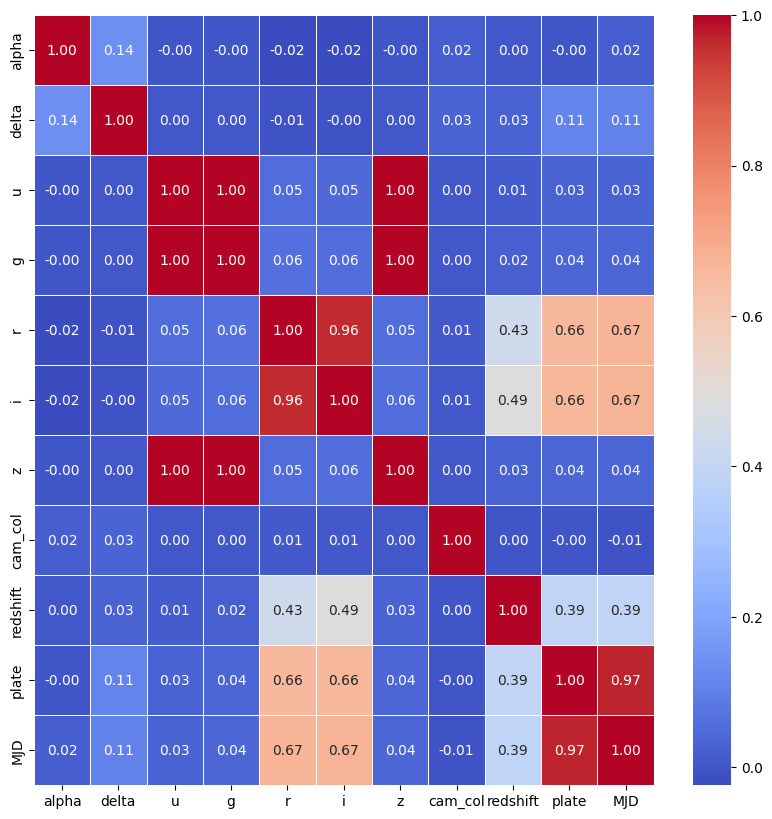

In [15]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_num.corr(), annot = True, fmt = ".2f", linewidths = .5, cmap='coolwarm')
plt.show()

In [16]:
correlation_matrix = df_num.corr()
threshold = 0.9 # Defined a threshold for high correlation

high_correlation_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold
]
unique_pairs = set(tuple(sorted(pair[:2])) + (pair[2],) for pair in high_correlation_pairs)

# Display the results
for pair in unique_pairs:
    print(f"Columns: {pair[0]} and {pair[1]} with correlation: {pair[2]:.2f}")

Columns: i and r with correlation: 0.96
Columns: g and u with correlation: 1.00
Columns: u and z with correlation: 1.00
Columns: g and z with correlation: 1.00
Columns: MJD and plate with correlation: 0.97


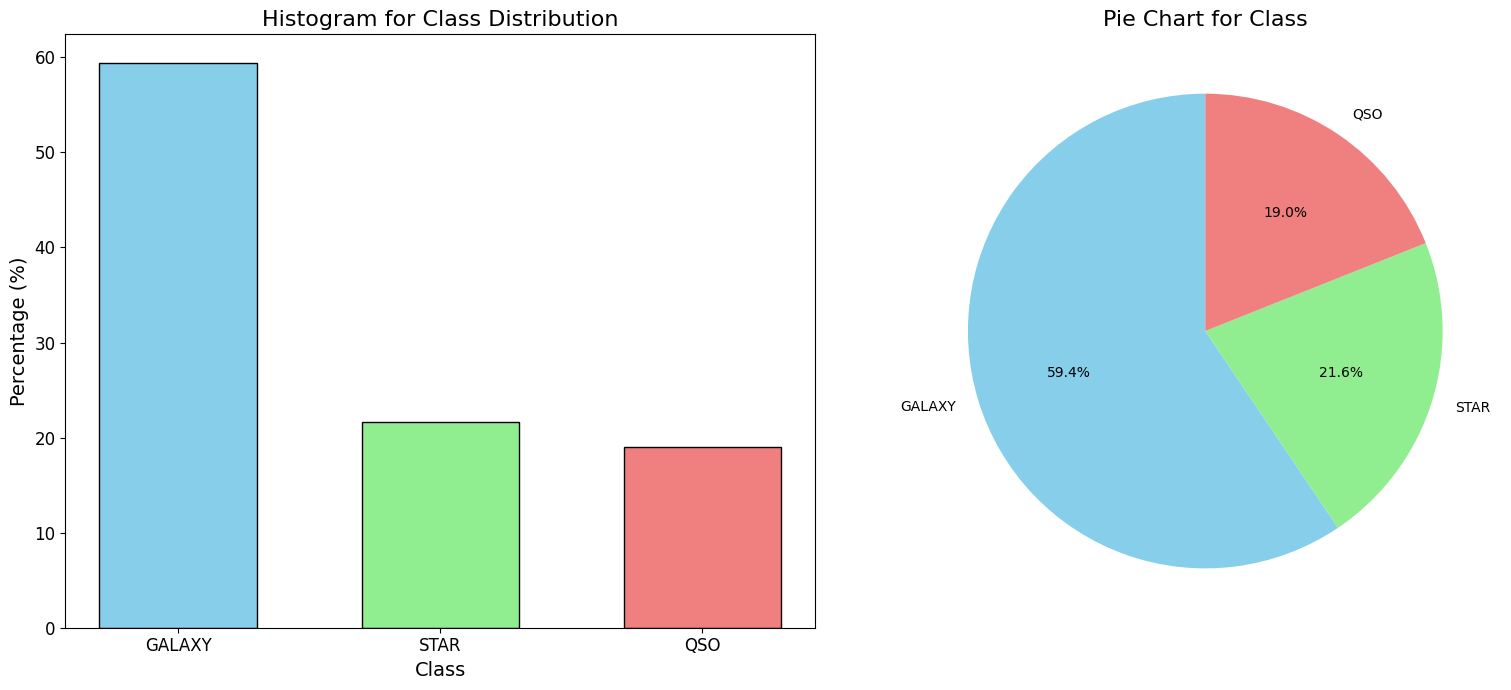

In [17]:
labels=df['class'].value_counts(normalize=True)*100

classlabels = ['GALAXY', 'STAR', 'QSO']
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.figure(figsize=(16, 7))

# Histogram (left subplot)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.bar(classlabels, labels, color=colors, edgecolor='black', width=0.6)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Histogram for Class Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Pie chart (right subplot)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.pie(labels, labels=classlabels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Pie Chart for Class', fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [18]:
# Time Series analysis using MJD
# Converting MJd to Date dd-mm-yyyy format
df['Date'] = [t.strftime('%d-%m-%Y') for t in Time(df['MJD'], format='mjd').to_datetime()]
print(df[['MJD', 'Date']].head())

     MJD        Date
0  56354  03-03-2013
1  58158  09-02-2018
2  55592  31-01-2011
3  58039  13-10-2017
4  56187  17-09-2012


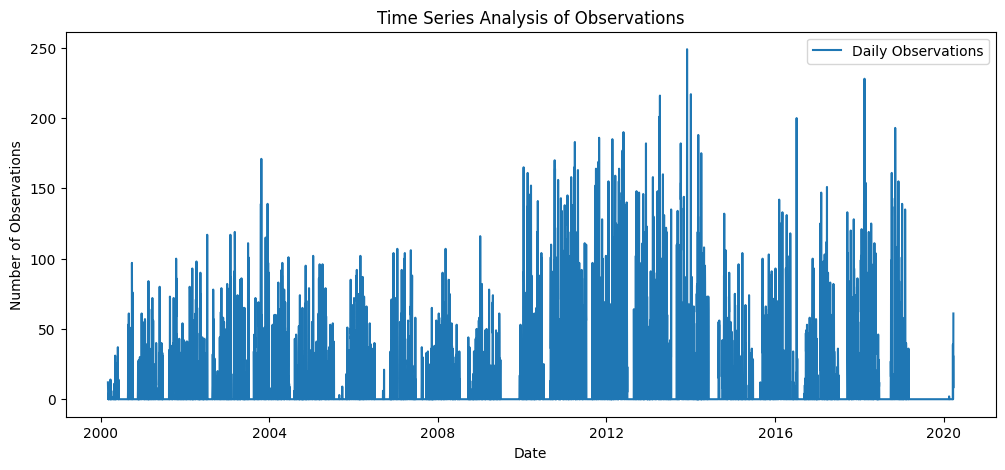

In [19]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Count Observations per Day
daily_counts = df.resample('D', on='Date').count()

# Plot Time Series
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_counts, x=daily_counts.index, y='class', label='Daily Observations')
plt.xlabel("Date")
plt.ylabel("Number of Observations")
plt.title("Time Series Analysis of Observations")
plt.legend()
plt.show()

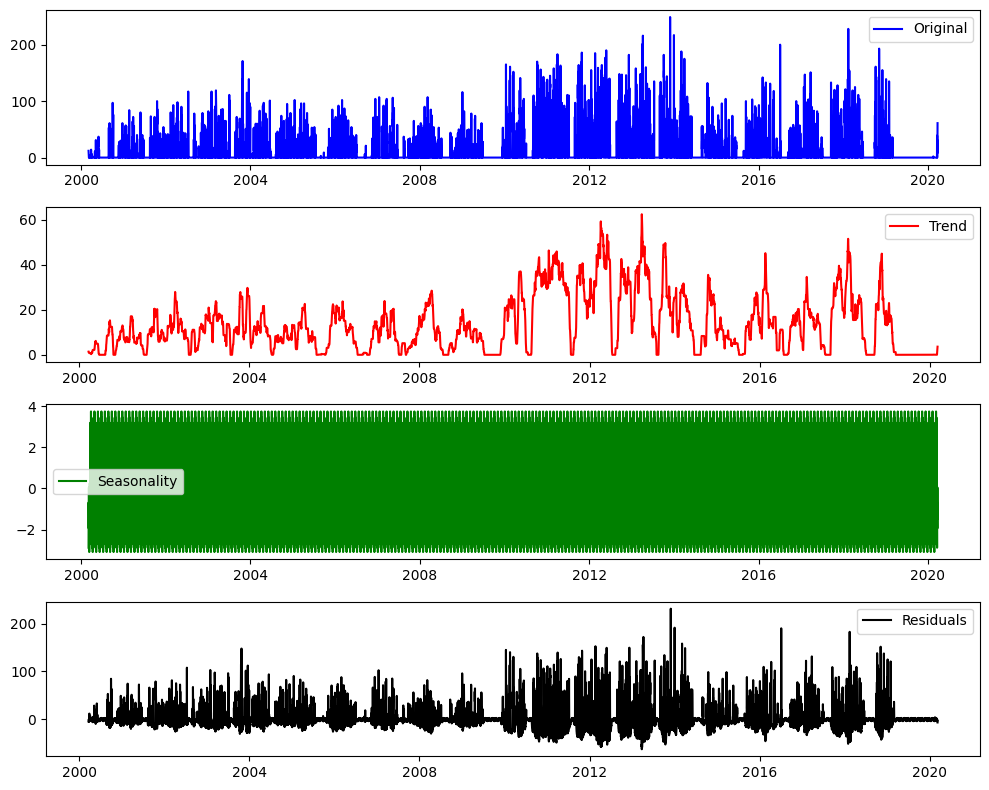

In [20]:
# We can break down the time series into trend, seasonality, and residuals.
daily_counts = daily_counts.rename(columns={'class': 'observations'})
decomposition = seasonal_decompose(daily_counts['observations'], model='additive', period=30)

plt.figure(figsize=(10, 8))

plt.subplot(411)#Observation
plt.plot(decomposition.observed, label='Original', color='blue')
plt.legend()

plt.subplot(412)#Trend
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend()

plt.subplot(413)#Seasonality
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(414)#Residuals
plt.plot(decomposition.resid, label='Residuals', color='black')
plt.legend()

plt.tight_layout()
plt.show()


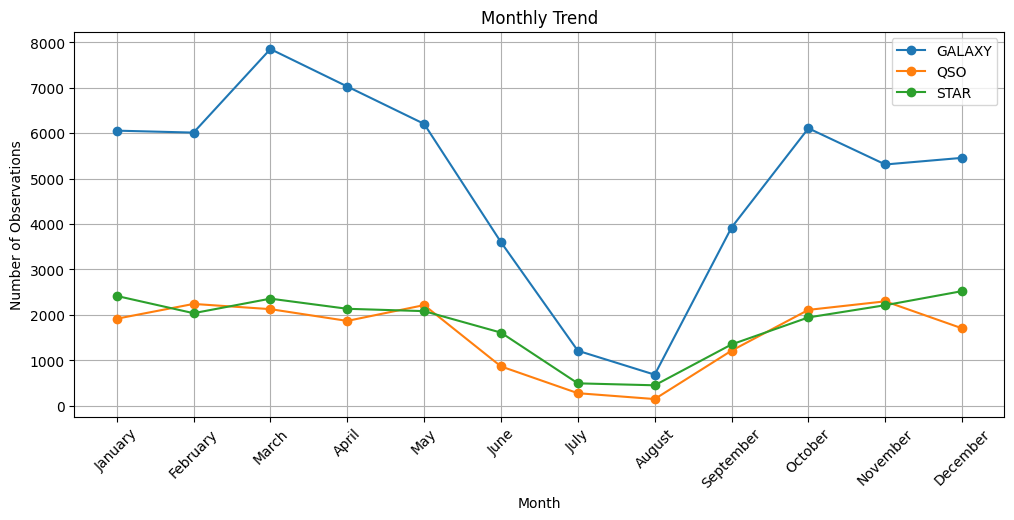

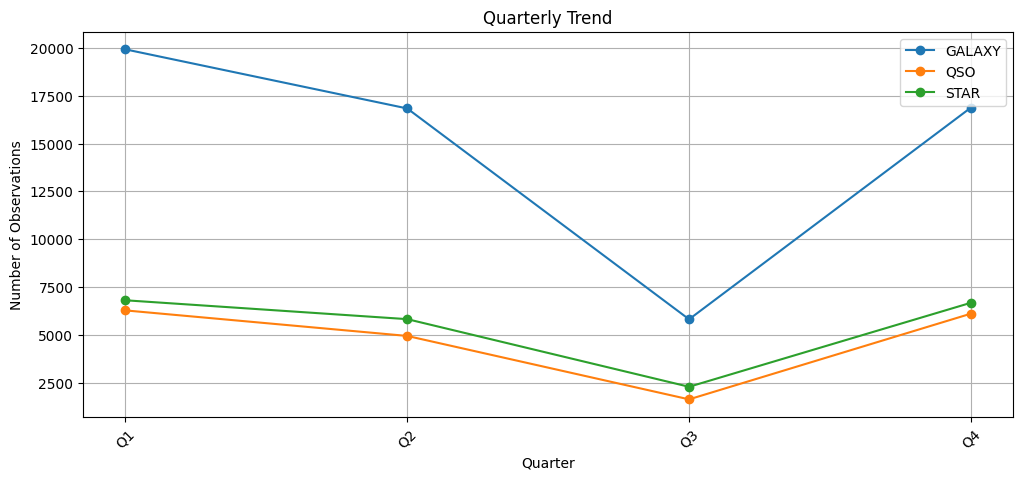

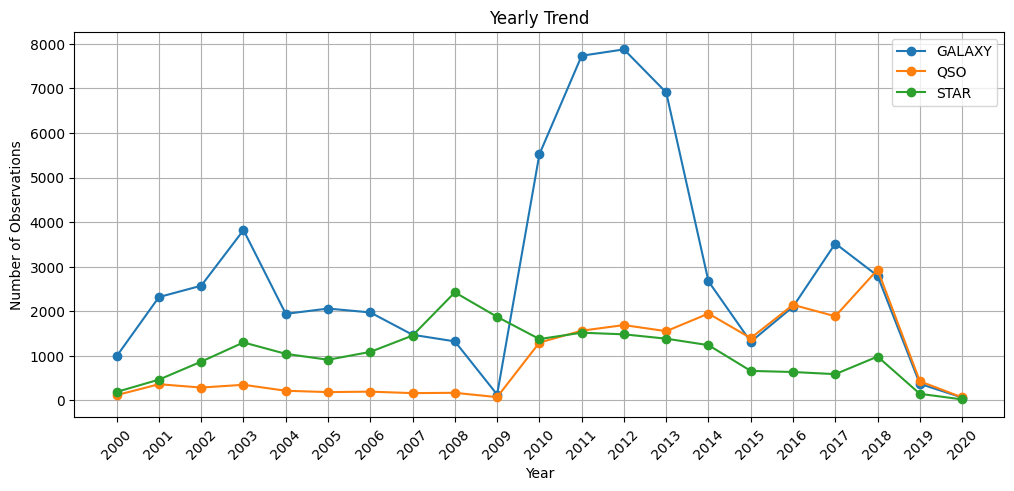

In [21]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract time features
df['month_name'] = df['Date'].dt.strftime('%B')  # Full month name
df['quarter_name'] = 'Q' + df['Date'].dt.quarter.astype(str)  # 'Q1', 'Q2', 'Q3', 'Q4'
df['year'] = df['Date'].dt.year  # Extract year

# Aggregate by class and month/quarter/year
monthly_counts = df.groupby(['month_name', 'class']).size().unstack(1)
quarterly_counts = df.groupby(['quarter_name', 'class']).size().unstack(1)
yearly_counts = df.groupby(['year', 'class']).size().unstack(1)

# Ensure months and quarters are in the correct order
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
quarter_order = ["Q1", "Q2", "Q3", "Q4"]

monthly_counts = monthly_counts.reindex(month_order)
quarterly_counts = quarterly_counts.reindex(quarter_order)
yearly_counts.index = yearly_counts.index.astype(int)  # Ensure years remain as integers

# Function to plot time series
def plot_time_series(data, title, xlabel):
    plt.figure(figsize=(12, 5))

    for col in data.columns:
        plt.plot(data.index, data[col], marker='o', label=col)

    if data.index.dtype == 'int64':  # Yearly plot
        plt.xticks(ticks=data.index, labels=data.index.astype(str), rotation=45)
    else:  # Monthly or Quarterly plot
        plt.xticks(rotation=45)

    plt.xlabel(xlabel)
    plt.ylabel("Number of Observations")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_time_series(monthly_counts, "Monthly Trend", "Month")
plot_time_series(quarterly_counts, "Quarterly Trend", "Quarter")
plot_time_series(yearly_counts, "Yearly Trend", "Year")

### Observation from the EDA 
<br>Skewness: in all columns - 
<br>outliers: in filter columns - use log or sqrt transformation
<br>Multicollinearity: among some columns
<br>Duplicates: N/A
<br>None: None

In [22]:
#Removing columns which are highly correlated
df=df.drop(['g', 'z', 'month_name', 'quarter_name', 'year', 'MJD', 'Date'], axis=1)

Feature: alpha, Score: 0.01787
Feature: delta, Score: 0.01786
Feature: u, Score: 0.09107
Feature: r, Score: 0.06105
Feature: i, Score: 0.08917
Feature: cam_col, Score: 0.00482
Feature: redshift, Score: 0.65507
Feature: plate, Score: 0.06308


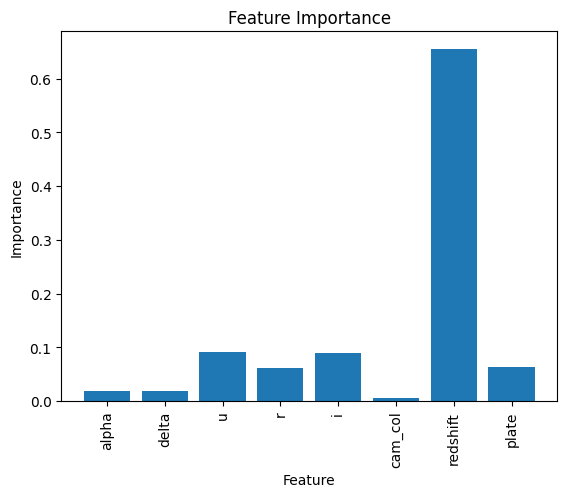

In [23]:
#Checking feature importance using Random Forest Classifier
set_config(display='diagram')
# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Label encode the target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X.columns)  # Pass through all features as they are
    ])

# Define the model
model = RandomForestClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline.named_steps['model'].feature_importances_

pipeline
# Summarize feature importance
feature_names = X.columns
for i, v in enumerate(feature_importances):
    print('Feature: %s, Score: %.5f' % (feature_names[i], v))

# Plot feature importance
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [24]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['alpha', 'delta', 'u', 'r', 'i', 'cam_col', 'redshift', 'plate'], dtype='object'))])),
                ('model', RandomForestClassifier())])

In [25]:
df=df.drop(['cam_col', 'r', 'plate'], axis=1) # removing columns with high collinearity and low feature importance

In [26]:
X = df.drop(columns='class')
y = df[['class']]

In [27]:
#Handle Outliers by Mean Value imputation
for i in X.columns:
    # Detect outliers using IQR method
    Q1 = X[i].quantile(0.25)
    Q3 = X[i].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (X[i] < lower_bound) | (X[i] > upper_bound)

    # Calculate mean without outliers, handling NaN cases
    mean_value = X.loc[~outliers, i].mean()
    mean_value = mean_value if pd.notna(mean_value) else X[i].mean()  # Fallback

    # Replace outliers with mean
    X.loc[outliers, i] = mean_value

<Axes: title={'center': 'Boxplot for redshift'}, xlabel='class', ylabel='redshift'>

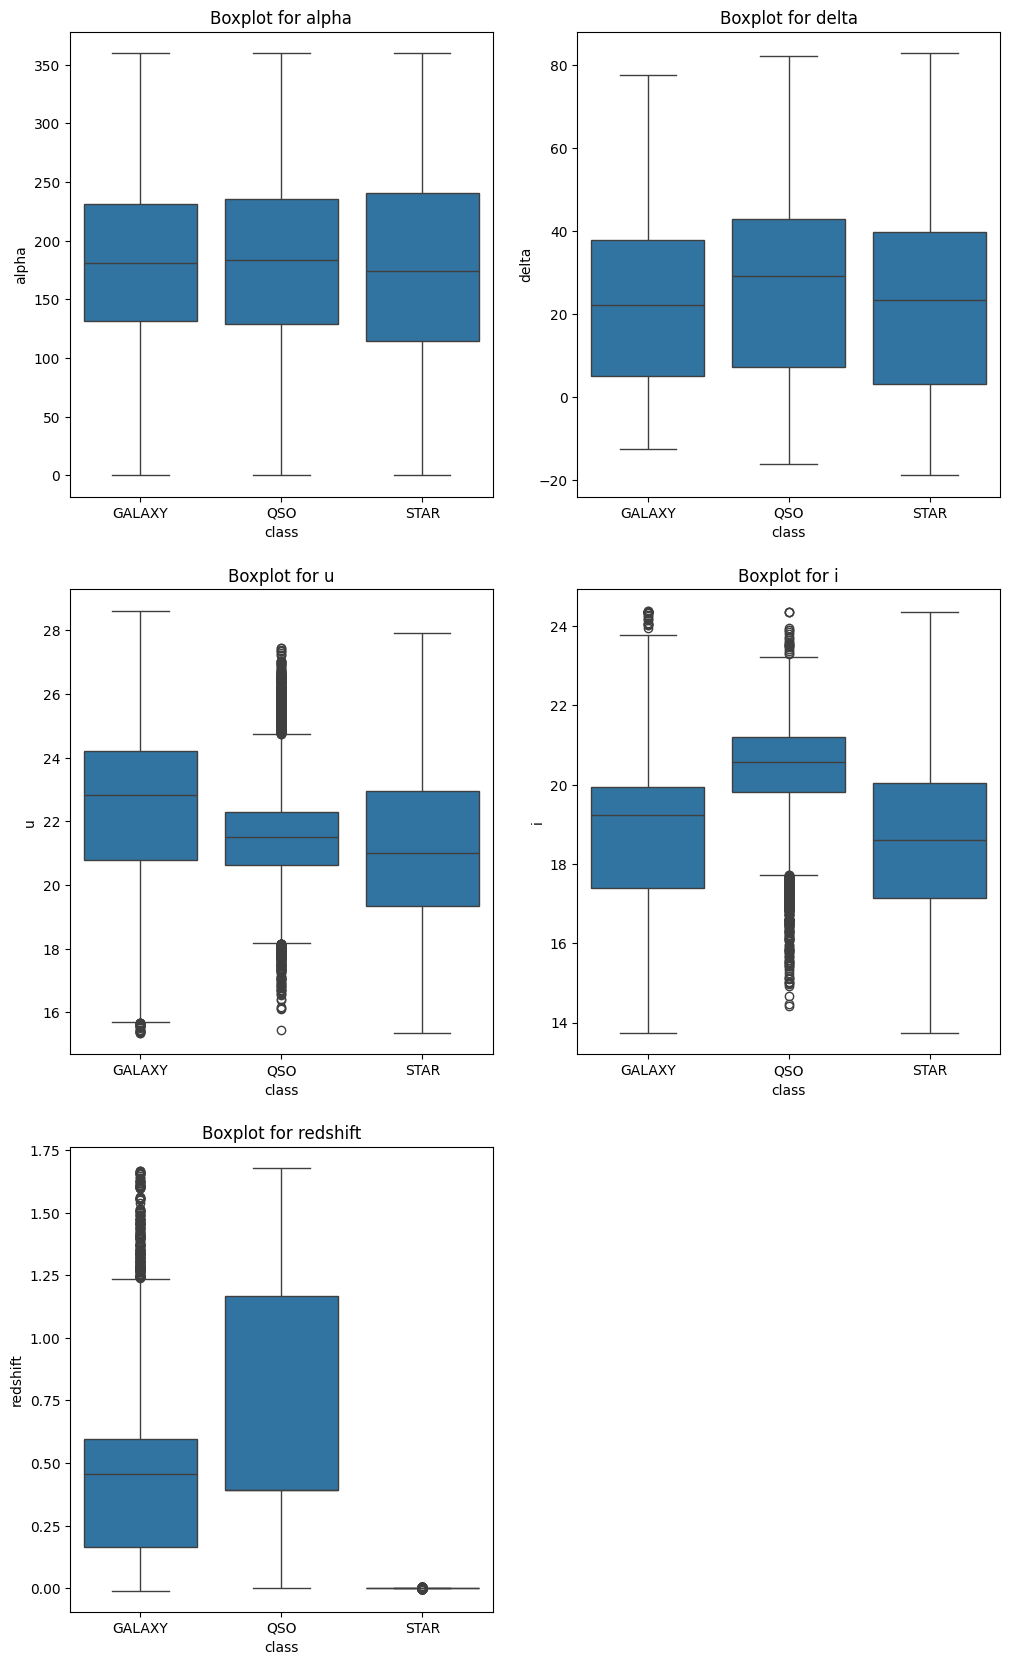

In [28]:
#Checking for outliers using boxplot
plt.figure(figsize=(12, 35))#Defining size of the plots
plt.subplot(5,2,1)
plt.title('Boxplot for alpha')#Giving title to each plots
sns.boxplot(x=y['class'], y=X['alpha'])
plt.subplot(5,2,2)
plt.title('Boxplot for delta')
sns.boxplot(x=y['class'], y=X['delta'])
plt.subplot(5,2,3)
plt.title('Boxplot for u')
sns.boxplot(x=y['class'], y=X['u'])
plt.subplot(5,2,4)
plt.title('Boxplot for i')
sns.boxplot(x=y['class'], y=X['i'])
plt.subplot(5,2,5)
plt.title('Boxplot for redshift')
sns.boxplot(x=y['class'], y=X['redshift'])

<Axes: xlabel='class', ylabel='u'>

<Figure size 1500x500 with 0 Axes>

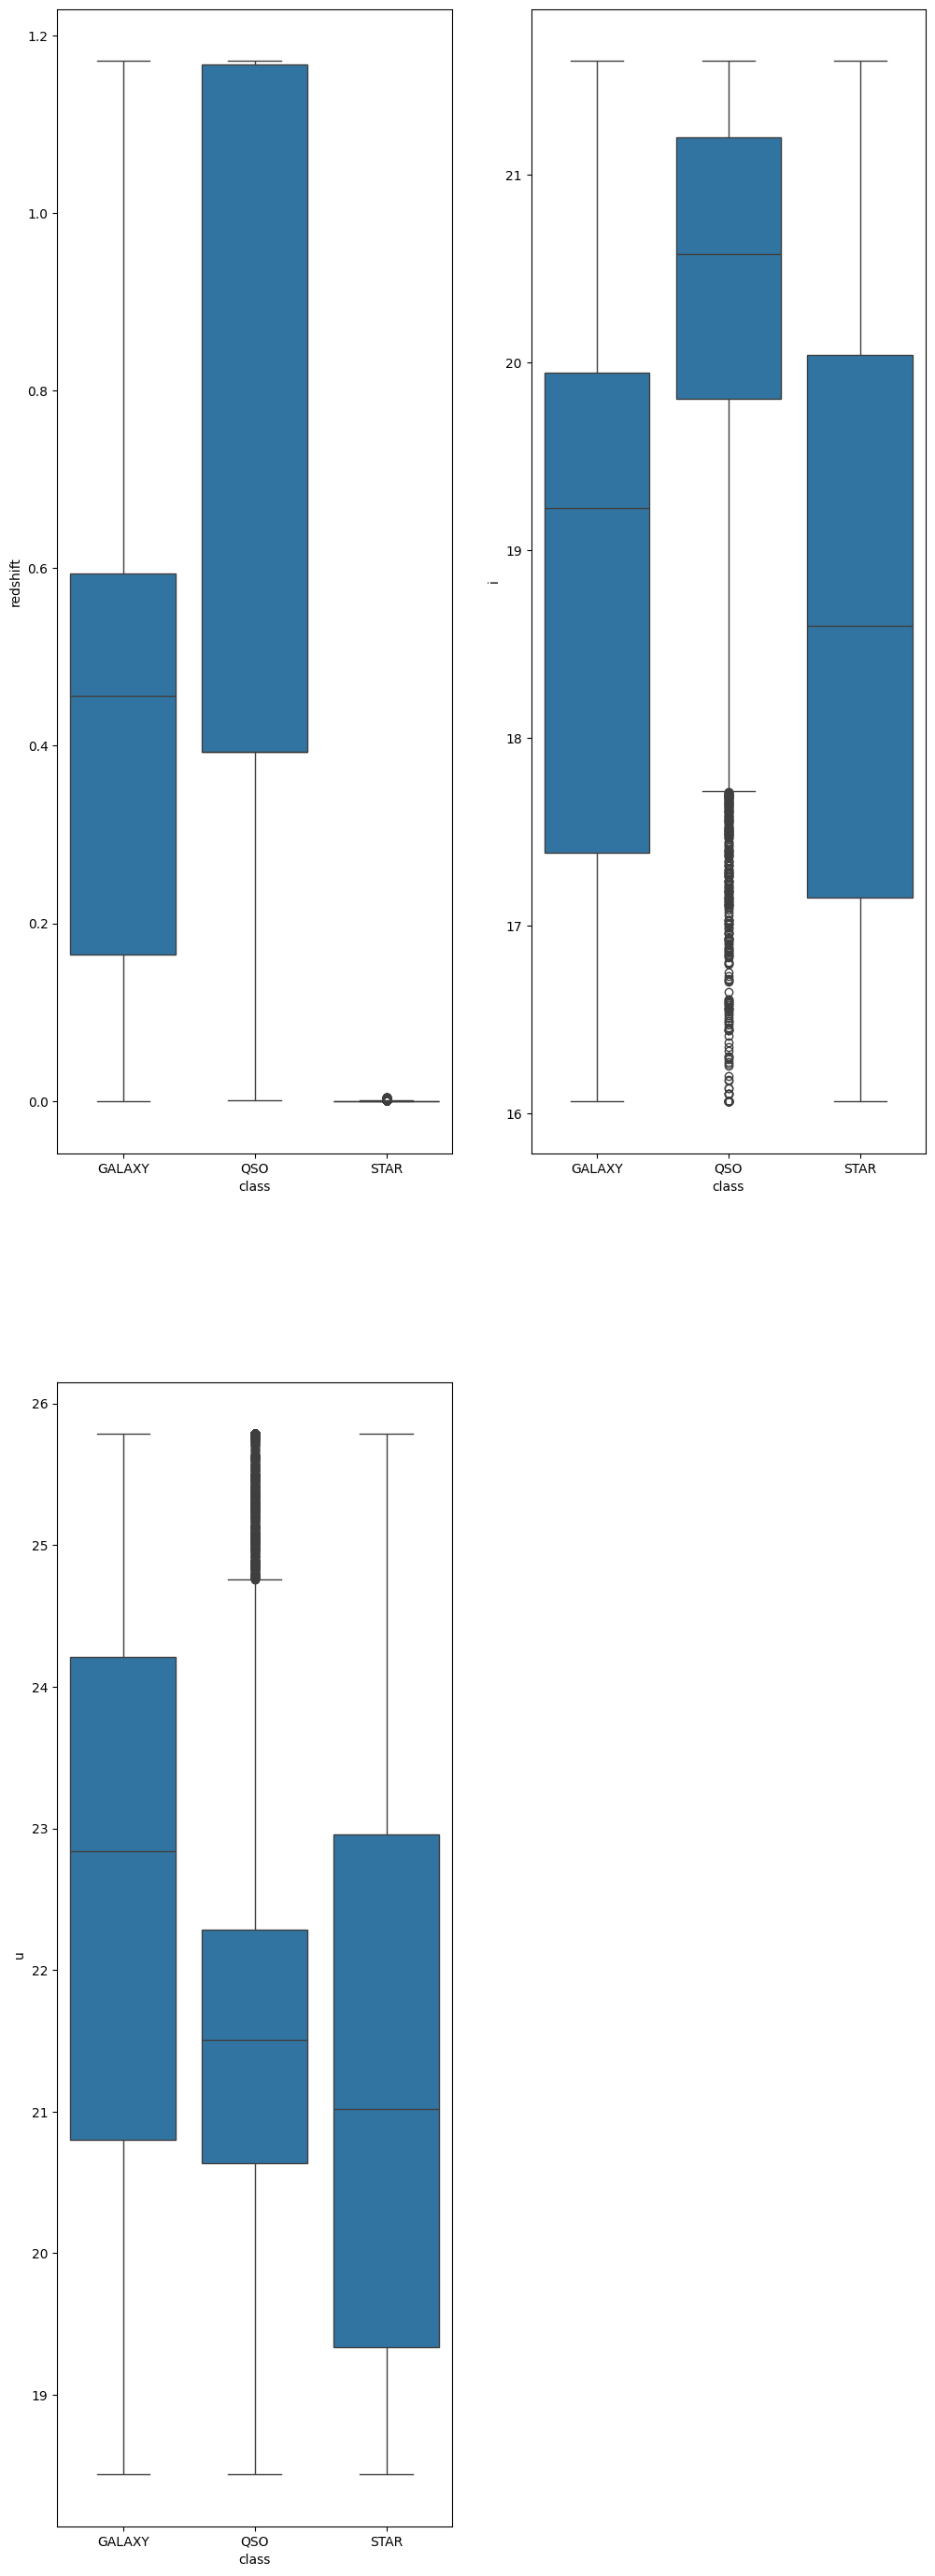

In [29]:
columns_to_winsorize = ['u', 'i', 'redshift']

X_winsorized = X.copy()                                                             

# Apply Winsorization
for col in columns_to_winsorize:
    X_winsorized[col] = winsorize(X[col], limits=[0.05, 0.05])  

# Plot before & after Winsorization
plt.figure(figsize=(15, 5))

plt.figure(figsize=(12, 35))#Defining size of the plots
plt.subplot(2,2,1)
sns.boxplot(x=y['class'], y=X['redshift'])
plt.subplot(2,2,2)
sns.boxplot(x=y['class'], y=X['i'])
plt.subplot(2,2,3)
sns.boxplot(x=y['class'], y=X['u'])

In [30]:
transformer=PowerTransformer('yeo-johnson')#We apply yeo-johnson because it contains negetive values
X_transformed=pd.DataFrame(transformer.fit_transform(X_winsorized), columns=X.columns)

<Axes: title={'center': 'Boxplot for redshift'}, xlabel='class', ylabel='redshift'>

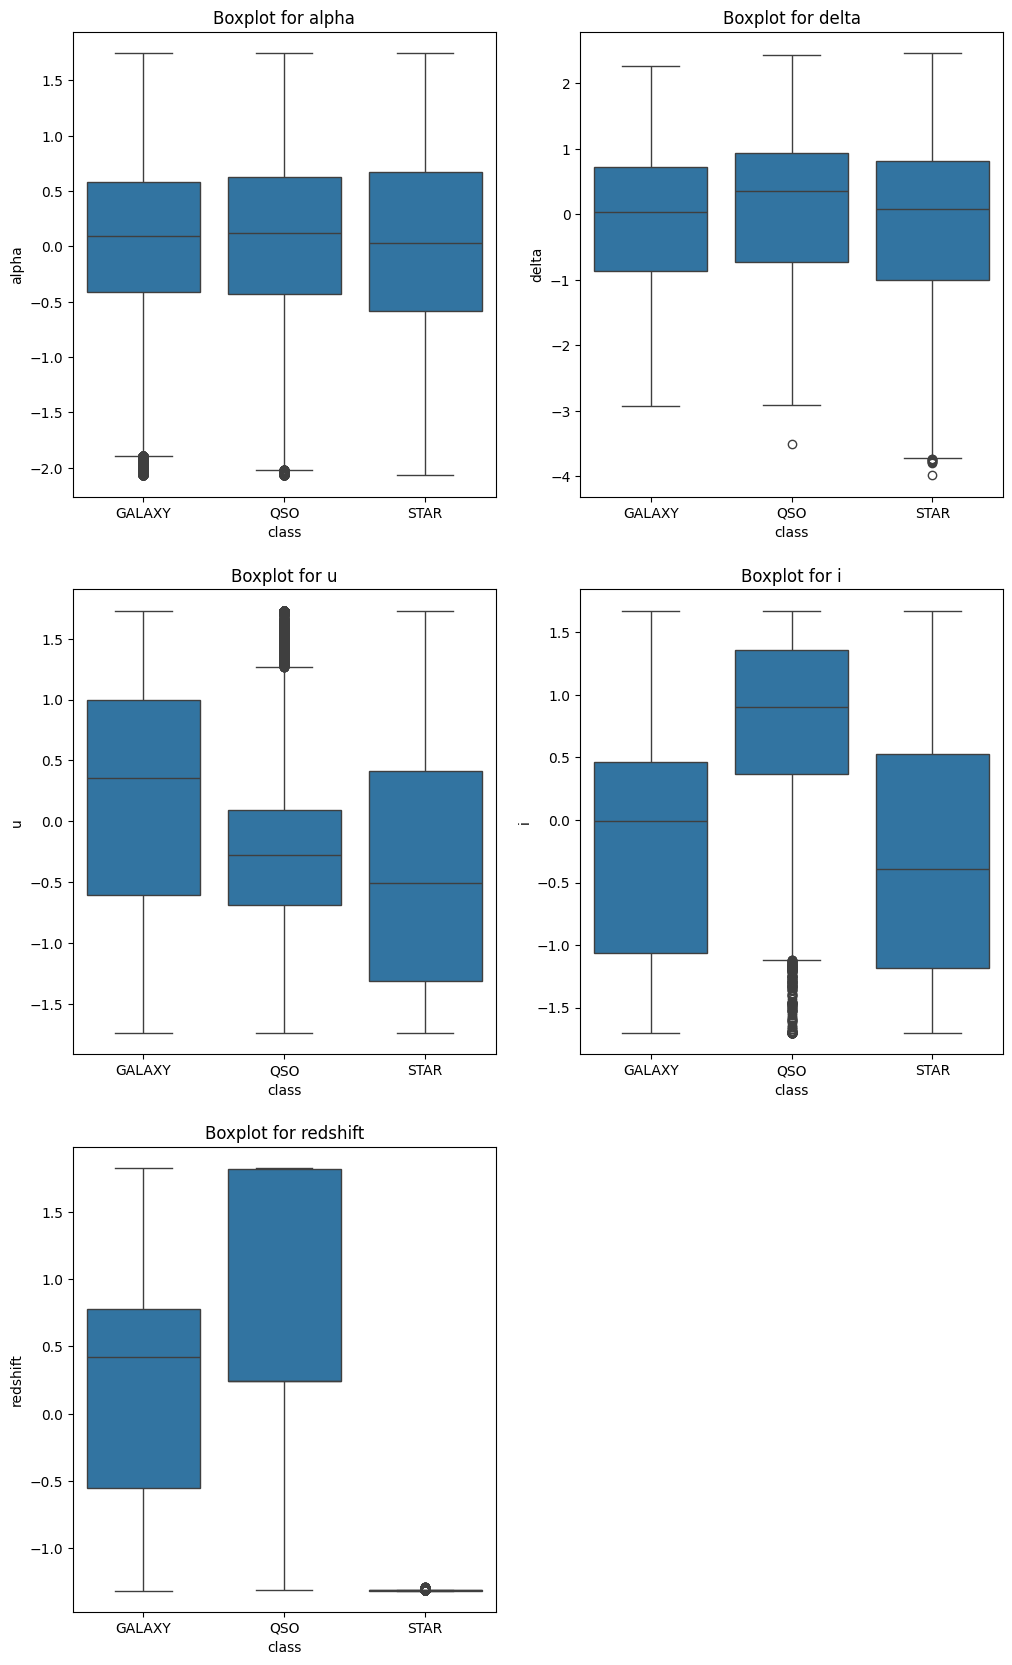

In [31]:
#Checking for outliers using boxplot
plt.figure(figsize=(12, 35))#Defining size of the plots
plt.subplot(5,2,1)
plt.title('Boxplot for alpha')#Giving title to each plots
sns.boxplot(x=y['class'], y=X_transformed['alpha'])
plt.subplot(5,2,2)
plt.title('Boxplot for delta')
sns.boxplot(x=y['class'], y=X_transformed['delta'])
plt.subplot(5,2,3)
plt.title('Boxplot for u')
sns.boxplot(x=y['class'], y=X_transformed['u'])
plt.subplot(5,2,4)
plt.title('Boxplot for i')
sns.boxplot(x=y['class'], y=X_transformed['i'])
plt.subplot(5,2,5)
plt.title('Boxplot for redshift')
sns.boxplot(x=y['class'], y=X_transformed['redshift'])

In [32]:
df_num=X_transformed
from scipy.stats import shapiro
for i in df_num.columns:
    stat, p_value = shapiro(df_num[i])
    print(f'Results for {i}')
    print(f"Shapiro-Wilk Test Statistic:{stat}")
    print(f"p-value: {p_value}")
    if p_value > 0.05:
        print("The data appears to follow a normal distribution.")
    else:
        print("The data does not follow a normal distribution.")
    print('-'*50)

Results for alpha
Shapiro-Wilk Test Statistic:0.9506706276662442
p-value: 9.147652665611731e-94
The data does not follow a normal distribution.
--------------------------------------------------
Results for delta
Shapiro-Wilk Test Statistic:0.9755107001237022
p-value: 4.441525438688982e-77
The data does not follow a normal distribution.
--------------------------------------------------
Results for u
Shapiro-Wilk Test Statistic:0.9667754321558099
p-value: 3.835849913215081e-84
The data does not follow a normal distribution.
--------------------------------------------------
Results for i
Shapiro-Wilk Test Statistic:0.9586322032942416
p-value: 2.052982561377393e-89
The data does not follow a normal distribution.
--------------------------------------------------
Results for redshift
Shapiro-Wilk Test Statistic:0.916755153631144
p-value: 2.5335867981393306e-107
The data does not follow a normal distribution.
--------------------------------------------------


In [33]:
X=X_transformed.copy()

In [30]:
label = LabelEncoder()
y = pd.Series(label.fit_transform(y), name="class")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
# To prevent Data leakage we used fit transform on training data and transform on test data
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [33]:
X_train=X_train_scaled
X_test=X_test_scaled

### Model Selection and Training

In [34]:
# Define model
svc = SVC(C=1, kernel='linear', probability=True)  # Enable probability for ROC AUC

# Fit model on full training data
svc.fit(X_train, y_train)

# Predictions
svc_preds = svc.predict(X_test)
svc_probs = svc.predict_proba(X_test)[:, 1]  # Get probability estimates for the positive class

# Evaluate model
svc_accuracy = svc.score(X_test, y_test)

# Compute metrics
svc_precision = precision_score(y_test, svc_preds, average="macro")
svc_recall = recall_score(y_test, svc_preds, average="macro")
svc_f1 = f1_score(y_test, svc_preds, average="macro")

# Print results
print(f"SVC Accuracy: {svc_accuracy:.4f}")
print(f"SVC Precision: {svc_precision:.4f}")
print(f"SVC Recall: {svc_recall:.4f}")
print(f"SVC F1-score: {svc_f1:.4f}")
print("Classification Report for SVC")
print(classification_report(y_test, svc_preds))

SVC Accuracy: 0.9177
SVC Precision: 0.9021
SVC Recall: 0.9089
SVC F1-score: 0.9054
Classification Report for SVC
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     17845
           1       0.80      0.80      0.80      5700
           2       0.97      1.00      0.99      6455

    accuracy                           0.92     30000
   macro avg       0.90      0.91      0.91     30000
weighted avg       0.92      0.92      0.92     30000



In [35]:
train_accuracy = svc.score(X_train, y_train)
test_accuracy = svc.score(X_test, y_test)

In [36]:
print("train accuracy", train_accuracy)
print("test_accuracy", test_accuracy)

train accuracy 0.9170142857142857
test_accuracy 0.9177


Random Forest Accuracy: 0.9733
Random Forest Precision: 0.9728
Random Forest Recall: 0.9650
Random Forest F1-score: 0.9688
Classification Report for Random Forest Classifier
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17845
           1       0.95      0.91      0.93      5700
           2       1.00      1.00      1.00      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.97     30000
weighted avg       0.97      0.97      0.97     30000

ROC-AUC Score: 0.9932


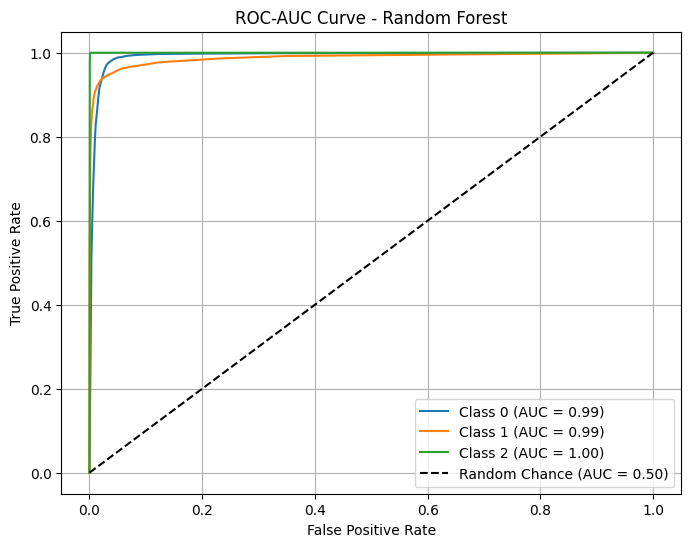

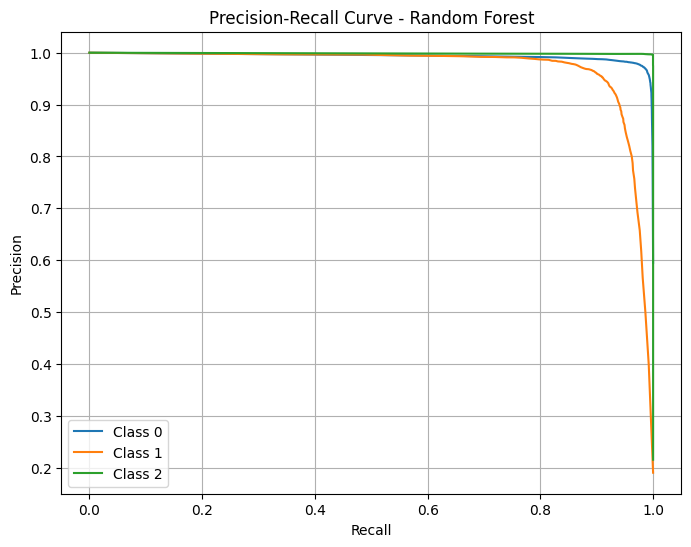

In [38]:
from sklearn.preprocessing import label_binarize
# Define and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)

# Compute evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds, average="macro")
rf_recall = recall_score(y_test, rf_preds, average="macro")
rf_f1 = f1_score(y_test, rf_preds, average="macro")

# Print metrics
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest Precision: {rf_precision:.4f}")
print(f"Random Forest Recall: {rf_recall:.4f}")
print(f"Random Forest F1-score: {rf_f1:.4f}")

print("Classification Report for Random Forest Classifier")
print(classification_report(y_test, rf_preds))

# Binarize labels for multi-class ROC-AUC & Precision-Recall Curves
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute probability scores for ROC & PR curves
rf_proba = rf.predict_proba(X_test)  # Get class probabilities

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test_bin, rf_proba, average="macro", multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# **Plot ROC Curve**
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], rf_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()

# **Plot Precision-Recall Curve**
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], rf_proba[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [39]:
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)
print("train accuracy", train_accuracy)
print("test_accuracy", test_accuracy)

train accuracy 0.9999857142857143
test_accuracy 0.9733



🔹 Training DecisionTree...

Best Params: {'clf__classifier__criterion': 'entropy', 'clf__classifier__max_depth': 10}
Train Accuracy: 0.9783
Test Accuracy: 0.9705
Accuracy: 0.9705
Precision: 0.9708
Recall: 0.9603
F1-score: 0.9653
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17845
           1       0.95      0.90      0.92      5700
           2       1.00      1.00      1.00      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.97     30000
weighted avg       0.97      0.97      0.97     30000

ROC-AUC Score (macro-averaged): 0.9867


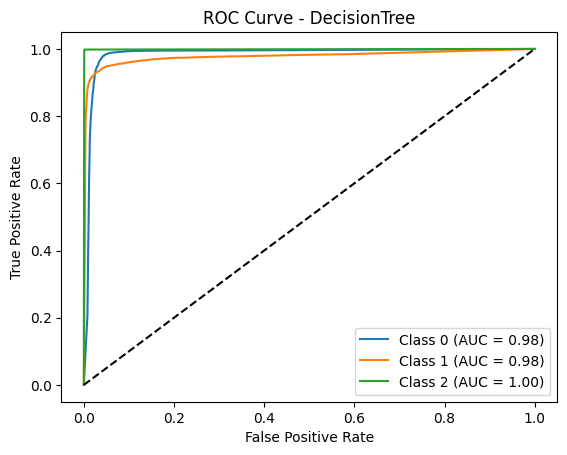

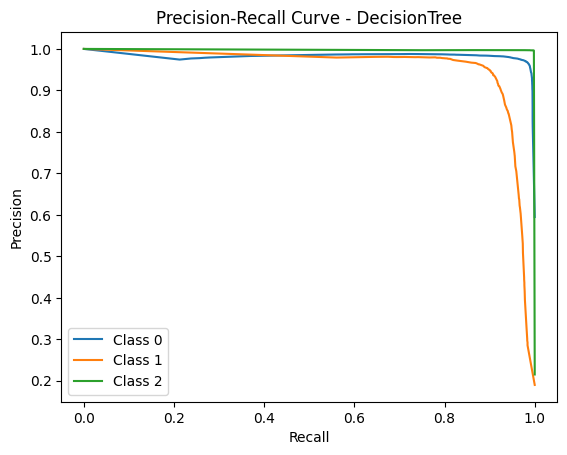


🔹 Training Naive_Bayes...

Best Params: {}
Train Accuracy: 0.8538
Test Accuracy: 0.8526
Accuracy: 0.8526
Precision: 0.8294
Recall: 0.8175
F1-score: 0.8225
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     17845
           1       0.65      0.57      0.60      5700
           2       0.98      0.99      0.99      6455

    accuracy                           0.85     30000
   macro avg       0.83      0.82      0.82     30000
weighted avg       0.85      0.85      0.85     30000

ROC-AUC Score (macro-averaged): 0.9439


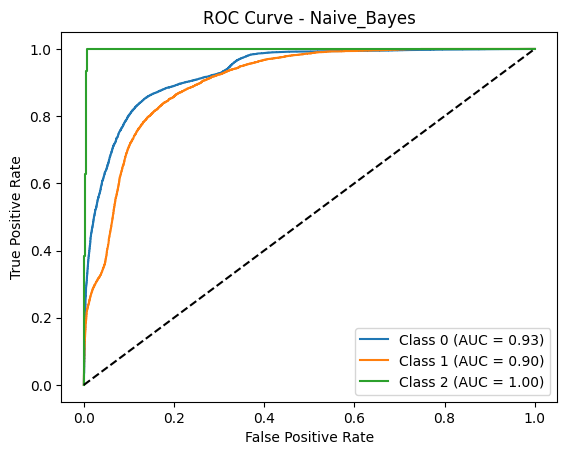

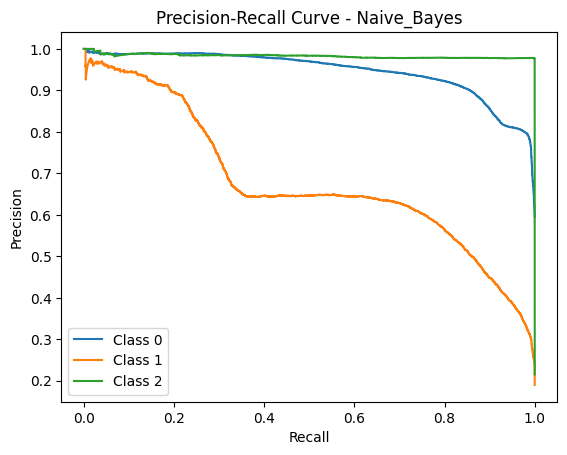


🔹 Training K_Nearest_Neighbours...

Best Params: {'clf__classifier__n_neighbors': 10, 'clf__classifier__weights': 'distance'}
Train Accuracy: 1.0000
Test Accuracy: 0.9498
Accuracy: 0.9498
Precision: 0.9414
Recall: 0.9445
F1-score: 0.9426
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     17845
           1       0.92      0.88      0.90      5700
           2       0.94      1.00      0.97      6455

    accuracy                           0.95     30000
   macro avg       0.94      0.94      0.94     30000
weighted avg       0.95      0.95      0.95     30000

ROC-AUC Score (macro-averaged): 0.9824


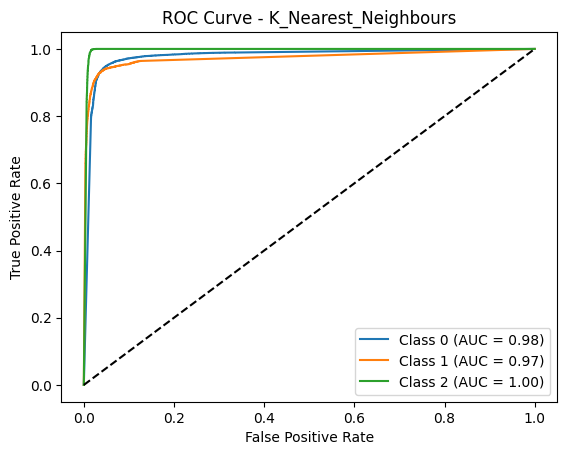

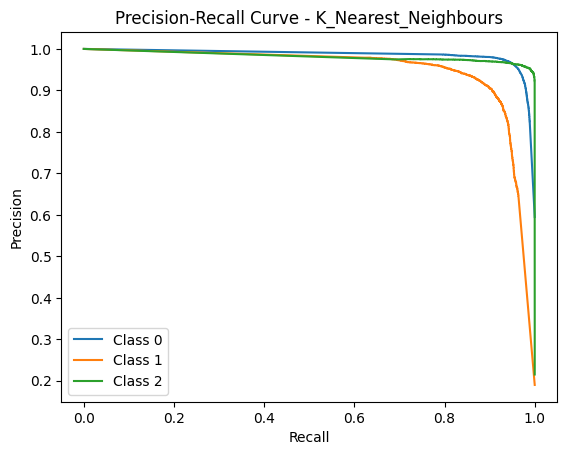

In [40]:
# Define models with hyperparameters for tuning
models = {
   "DecisionTree": (Pipeline([
       ("classifier", DecisionTreeClassifier())]),
       {"classifier__max_depth": [5, 10, 20], "classifier__criterion": ["gini", "entropy"]}
   ),
   "Naive_Bayes": (Pipeline([
       ("classifier", GaussianNB())]),
       {}  # No hyperparameters to tune for GaussianNB
   ),
   "K_Nearest_Neighbours": (Pipeline([
       ("classifier", KNeighborsClassifier())]),
       {"classifier__n_neighbors": [3, 5, 7, 10], "classifier__weights": ["uniform", "distance"]}
   )
}

# Function to train and evaluate models using train_test_split
def evaluate_models(X_train, X_test, y_train, y_test):
   lb = LabelBinarizer()  # For multi-class ROC-AUC & PR curves
   y_test_bin = lb.fit_transform(y_test)  # Convert to binary format (One-vs-Rest)

   for model_name, (model, params) in models.items():
       print(f"\n🔹 Training {model_name}...\n")
      
       # Define pipeline and properly reference classifier in hyperparameters
       pipeline = Pipeline([
           ('clf', model)
       ])
      
       param_grid = {f'clf__{key}': value for key, value in params.items()}
      
       # Use GridSearchCV to find the best hyperparameters
       grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)
       grid_search.fit(X_train, y_train)

       # Best model predictions
       best_model = grid_search.best_estimator_
       y_pred = best_model.predict(X_test)
       accuracy = accuracy_score(y_test, y_pred)
       precision = precision_score(y_test, y_pred, average='macro') 
       recall = recall_score(y_test, y_pred, average='macro') 
       f1 = f1_score(y_test, y_pred, average="macro")  # Fixed f1-score computation
       
       # Compute train and test accuracy
       train_accuracy = best_model.score(X_train, y_train)
       test_accuracy = best_model.score(X_test, y_test)
       
       print(f"Best Params: {grid_search.best_params_}")
       print(f"Train Accuracy: {train_accuracy:.4f}")
       print(f"Test Accuracy: {test_accuracy:.4f}")
       print(f"Accuracy: {accuracy:.4f}")
       print(f"Precision: {precision:.4f}")
       print(f"Recall: {recall:.4f}")
       print(f"F1-score: {f1:.4f}")
       print(classification_report(y_test, y_pred))

       # ROC-AUC Curve (Only for classifiers with probability output)
       if hasattr(best_model.named_steps['clf'], "predict_proba"):
           y_proba = best_model.predict_proba(X_test)
           roc_auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")  # Multi-class ROC-AUC
           print(f"ROC-AUC Score (macro-averaged): {roc_auc:.4f}")

           # Plot ROC Curve
           plt.figure()
           for i in range(len(lb.classes_)):  # Plot each class separately
               fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
               plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')

           plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
           plt.xlabel("False Positive Rate")
           plt.ylabel("True Positive Rate")
           plt.title(f"ROC Curve - {model_name}")
           plt.legend(loc="lower right")
           plt.show()
       else:
           print(f"{model_name} does not support probability predictions, skipping ROC-AUC.")

       # Precision-Recall Curve (For probability-based classifiers)
       if hasattr(best_model.named_steps['clf'], "predict_proba"):
           plt.figure()
           for i in range(len(lb.classes_)):
               precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
               plt.plot(recall, precision, label=f'Class {lb.classes_[i]}')

           plt.xlabel("Recall")
           plt.ylabel("Precision")
           plt.title(f"Precision-Recall Curve - {model_name}")
           plt.legend(loc="lower left")
           plt.show()
       else:
           print(f"{model_name} does not support probability predictions, skipping Precision-Recall Curve.")

# Run evaluation using train_test_split
evaluate_models(X_train, X_test, y_train, y_test)


 Training AdaBoost...

Train Accuracy: 0.8382
Test Accuracy: 0.8362
Accuracy: 0.8362
Precision: 0.9085
Recall: 0.7205
F1 score: 0.7194
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     17845
           1       0.96      0.17      0.29      5700
           2       0.98      1.00      0.99      6455

    accuracy                           0.84     30000
   macro avg       0.91      0.72      0.72     30000
weighted avg       0.86      0.84      0.79     30000

ROC-AUC Score (micro-averaged): 0.9709


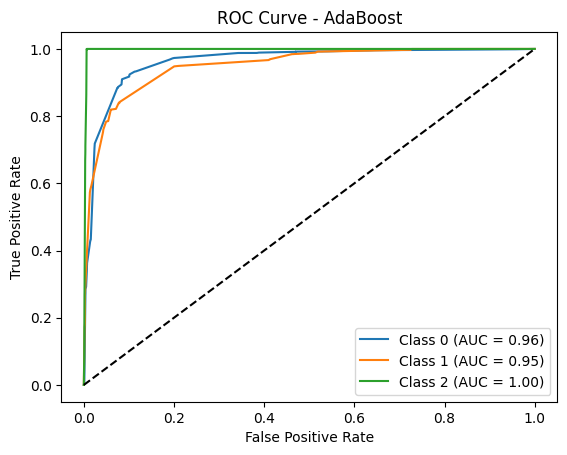

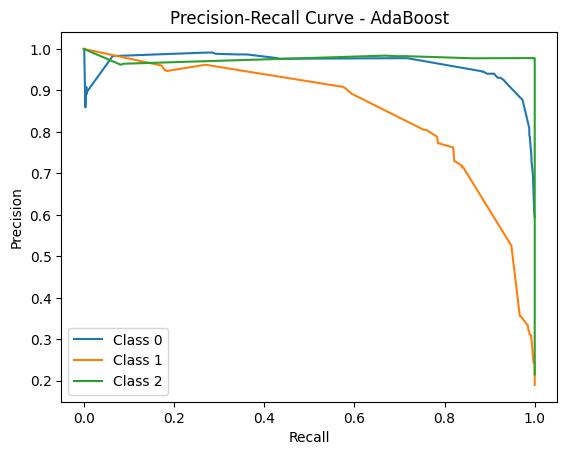


 Training Gradient Boosting...

Train Accuracy: 0.9784
Test Accuracy: 0.9729
Accuracy: 0.9729
Precision: 0.9726
Recall: 0.9643
F1 score: 0.9683
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17845
           1       0.95      0.91      0.93      5700
           2       1.00      1.00      1.00      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.97     30000
weighted avg       0.97      0.97      0.97     30000

ROC-AUC Score (micro-averaged): 0.9969


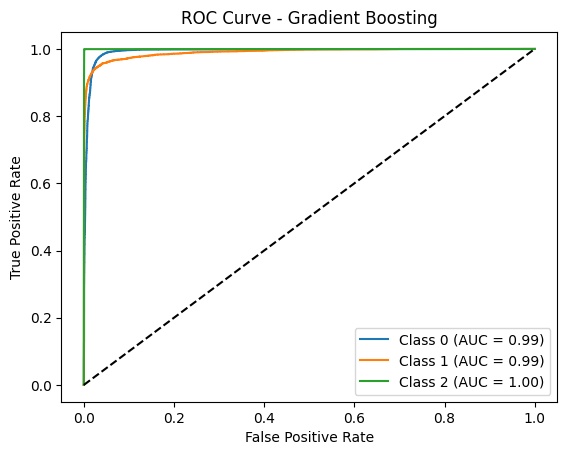

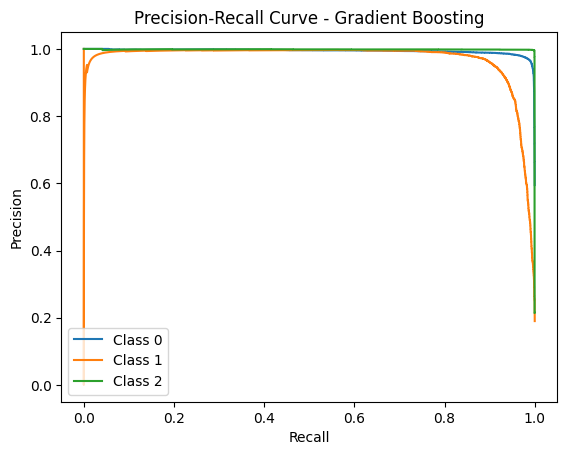

In [41]:
# Define models with hyperparameters for tuning
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
}

# Function to train and evaluate models
def evaluate_models(X_train, X_test, y_train, y_test):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    for model_name, model in models.items():
        print(f"\n Training {model_name}...\n")
        
        # Define pipeline
        pipeline = Pipeline([
            ('clf', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)

        # Compute train and test accuracy
        train_accuracy = pipeline.score(X_train, y_train)
        test_accuracy = pipeline.score(X_test, y_test)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')  
        recall = recall_score(y_test, y_pred, average='macro') 
        f1 = f1_score(y_test, y_pred, average="macro")  # Fixed f1-score computation

        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 score: {f1:.4f}")
        print(classification_report(y_test, y_pred))
        
        # ROC-AUC Curve (Only for classifiers with probability output)
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test_bin, y_proba, average="micro", multi_class="ovr")  # Multi-class ROC-AUC
            print(f"ROC-AUC Score (micro-averaged): {roc_auc:.4f}")

            # Plot ROC Curve
            plt.figure()
            for i in range(len(lb.classes_)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')

            plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {model_name}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            print(f"{model_name} does not support probability predictions, skipping ROC-AUC.")

        # Precision-Recall Curve (For probability-based classifiers)
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            plt.figure()
            for i in range(len(lb.classes_)):
                precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
                plt.plot(recall, precision, label=f'Class {lb.classes_[i]}')

            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve - {model_name}")
            plt.legend(loc="lower left")
            plt.show()
        else:
            print(f"{model_name} does not support probability predictions, skipping Precision-Recall Curve.")

# Run evaluation using train_test_split
evaluate_models(X_train, X_test, y_train, y_test)


🔹 Training AdaBoost...

Train Accuracy: 0.8382
Test Accuracy: 0.8362
Accuracy: 0.8362
Precision: 0.9085
Recall: 0.7205
F1 score: 0.7194
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     17845
           1       0.96      0.17      0.29      5700
           2       0.98      1.00      0.99      6455

    accuracy                           0.84     30000
   macro avg       0.91      0.72      0.72     30000
weighted avg       0.86      0.84      0.79     30000

ROC-AUC Score (micro-averaged): 0.9709


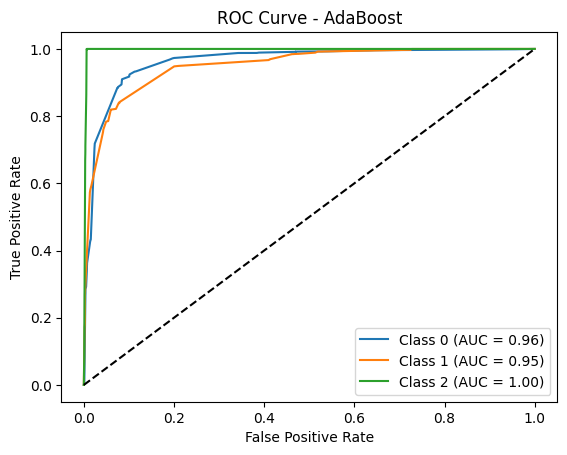

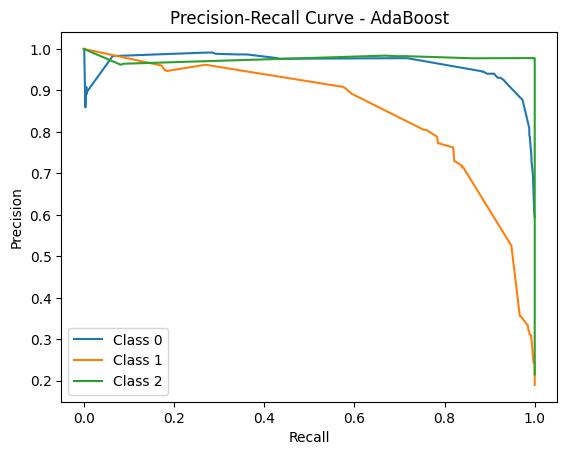


🔹 Training Gradient Boosting...

Train Accuracy: 0.9784
Test Accuracy: 0.9729
Accuracy: 0.9729
Precision: 0.9725
Recall: 0.9644
F1 score: 0.9683
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17845
           1       0.95      0.91      0.93      5700
           2       1.00      1.00      1.00      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.97     30000
weighted avg       0.97      0.97      0.97     30000

ROC-AUC Score (micro-averaged): 0.9969


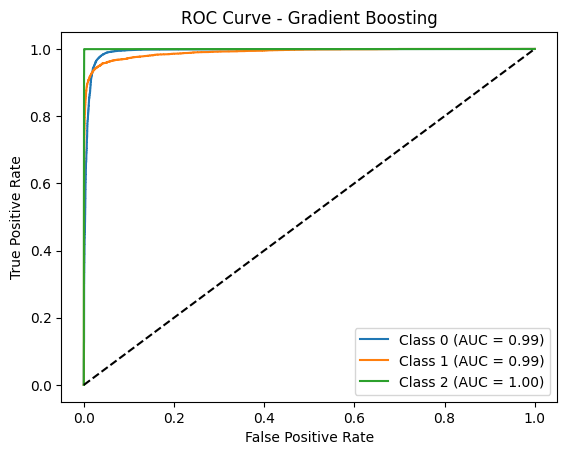

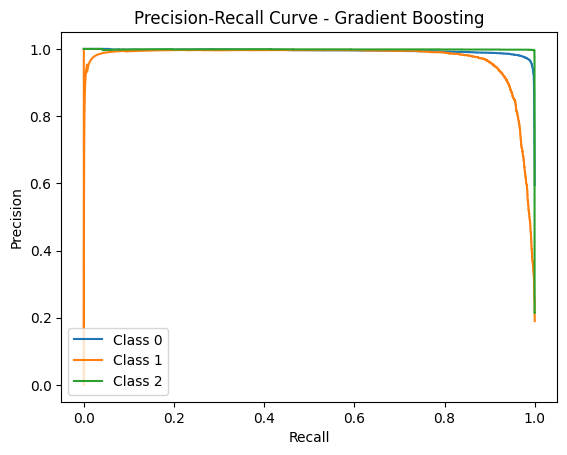


🔹 Training XGBoost...



AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [42]:
import xgboost as xgb

# Define models with hyperparameters for tuning
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5),
    "XGBoost": xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), 
                                  n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
}

# Function to train and evaluate models
def evaluate_models(X_train, X_test, y_train, y_test):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        
        # Define pipeline
        pipeline = Pipeline([
            ('clf', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)

        # Compute train and test accuracy
        train_accuracy = pipeline.score(X_train, y_train)
        test_accuracy = pipeline.score(X_test, y_test)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')  
        recall = recall_score(y_test, y_pred, average='macro') 
        f1 = f1_score(y_test, y_pred, average="macro")  # Fixed f1-score computation

        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 score: {f1:.4f}")
        print(classification_report(y_test, y_pred))
        
        # ROC-AUC Curve (Only for classifiers with probability output)
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test_bin, y_proba, average="micro", multi_class="ovr")  # Multi-class ROC-AUC
            print(f"ROC-AUC Score (micro-averaged): {roc_auc:.4f}")

            # Plot ROC Curve
            plt.figure()
            for i in range(len(lb.classes_)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')

            plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {model_name}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            print(f"{model_name} does not support probability predictions, skipping ROC-AUC.")

        # Precision-Recall Curve (For probability-based classifiers)
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            plt.figure()
            for i in range(len(lb.classes_)):
                precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
                plt.plot(recall, precision, label=f'Class {lb.classes_[i]}')

            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve - {model_name}")
            plt.legend(loc="lower left")
            plt.show()
        else:
            print(f"{model_name} does not support probability predictions, skipping Precision-Recall Curve.")

# Run evaluation using train_test_split
evaluate_models(X_train, X_test, y_train, y_test)